In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../utils/')
import FigureConfig as FC

In [2]:
alpha = torch.linspace(0,1,51)

In [3]:
result = torch.load('result.matrix')
result.shape

torch.Size([13, 10, 51, 8])

# figure

In [4]:
result_seed_mean = result.mean(1)
result_seed_mean.shape

torch.Size([13, 51, 8])

In [5]:
for ds in range(13):
    result_seed_mean[ds,:,2] = result_seed_mean[ds,:,2] / result_seed_mean[ds,0,2]
    result_seed_mean[ds,:,3] = result_seed_mean[ds,:,3] / result_seed_mean[ds,0,3]
    result_seed_mean[ds,:,6] = result_seed_mean[ds,:,6] / result_seed_mean[ds,0,6]
    result_seed_mean[ds,:,7] = result_seed_mean[ds,:,7] / result_seed_mean[ds,0,7]

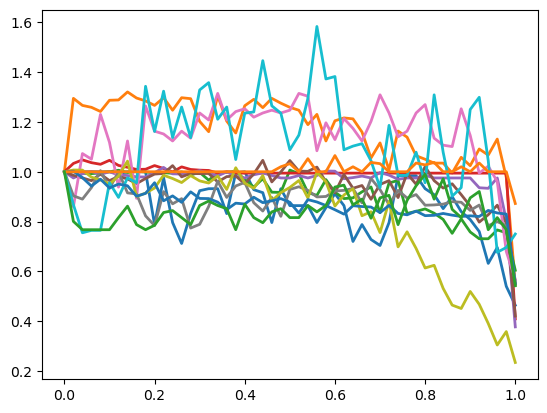

In [6]:
for ds in range(13):
    plt.plot(alpha, result_seed_mean[ds,:,2], lw=2, label=f'{ds}')

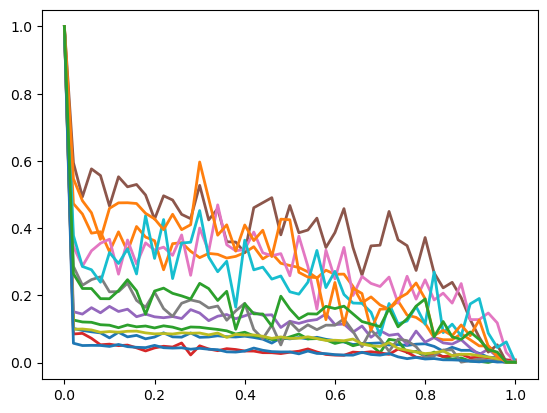

In [7]:
for ds in range(13):
    plt.plot(alpha, result_seed_mean[ds,:,3], lw=2)

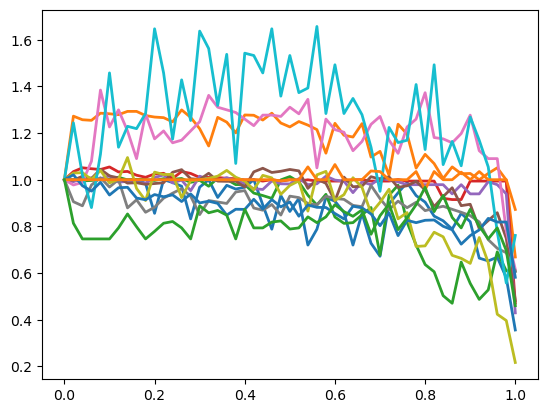

In [8]:
for ds in range(13):
    plt.plot(alpha, result_seed_mean[ds,:,6], lw=2)

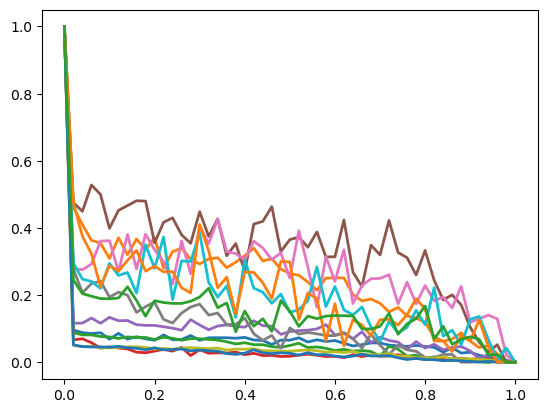

In [9]:
for ds in range(13):
    plt.plot(alpha, result_seed_mean[ds,:,7], lw=2)

# analysis

In [11]:
result.shape

torch.Size([13, 10, 51, 8])

In [12]:
pt_vs_ft = result.mean([0,1,2])
pt_vs_ft.shape

torch.Size([8])

In [13]:
print('acc and power from pretraining:', pt_vs_ft[2:4].tolist())

acc and power from pretraining: [0.6823652386665344, 553.2968139648438]


In [14]:
print('acc and power from fine tuning:', pt_vs_ft[6:].tolist())

acc and power from fine tuning: [0.6897575855255127, 528.6096801757812]


# Pareto

In [15]:
acc_points_pt = result[:,:,:,2]
power_points_pt = result[:,:,:,3] / 1e3
acc_points_ft = result[:,:,:,6]
power_points_ft = result[:,:,:,7] / 1e3
acc_points_pt.shape

torch.Size([13, 10, 51])

In [16]:
lims = [[0,1000 / 1e3],
        [0,1200 / 1e3],
        [0,2000 / 1e3],
        [0,2500 / 1e3],
        [0,1500 / 1e3],
        [0,1500 / 1e3],
        [0,1000 / 1e3],
        [0,1500 / 1e3],
        [0,3000 / 1e3],
        [0,1400 / 1e3],
        [0,1700 / 1e3],
        [0,1400 / 1e3],
        [0,1200 / 1e3]]

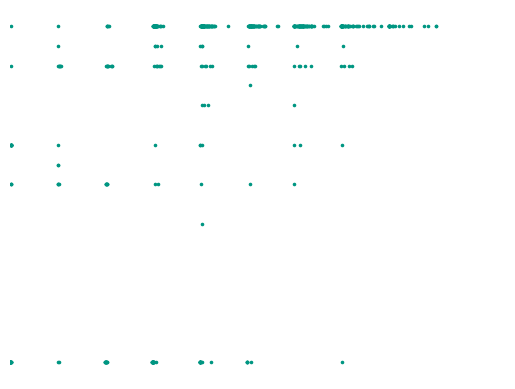

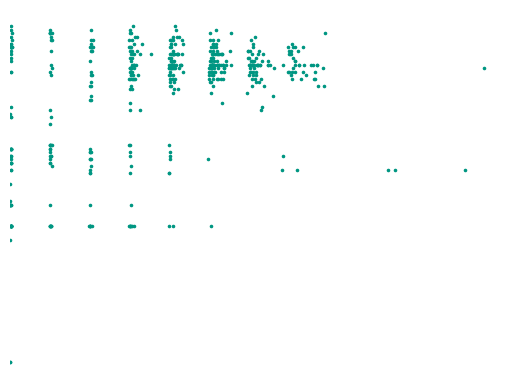

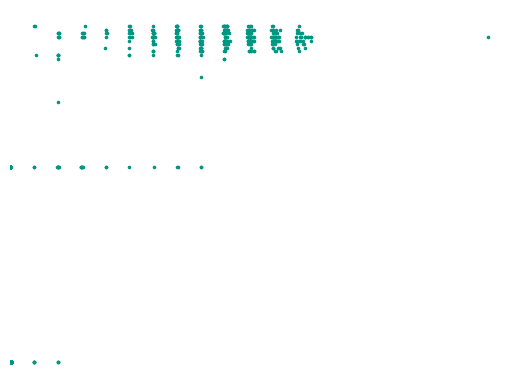

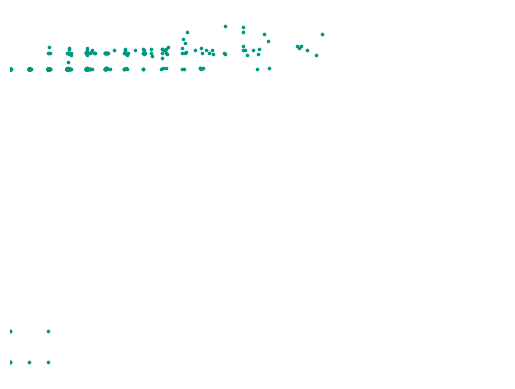

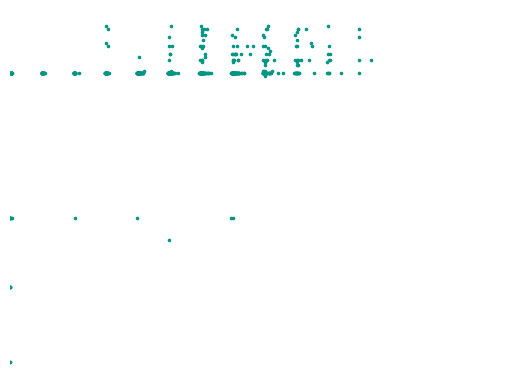

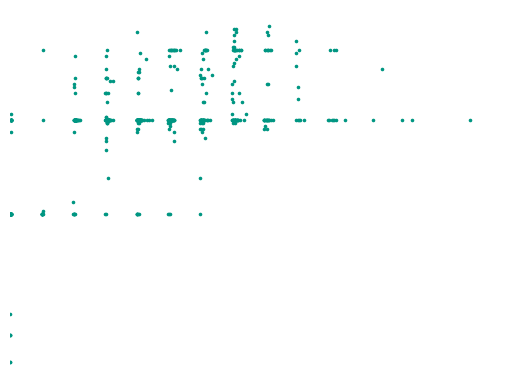

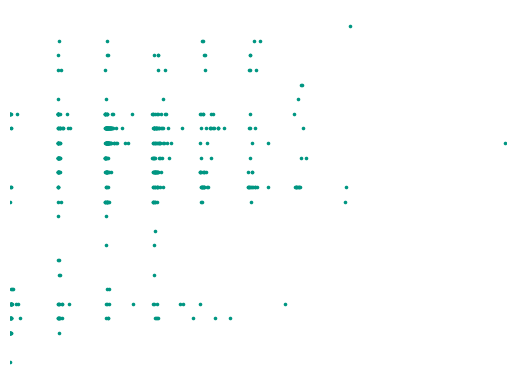

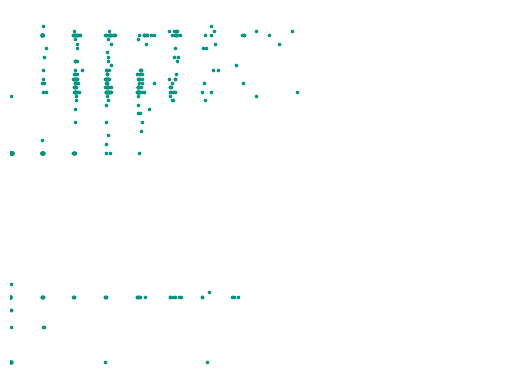

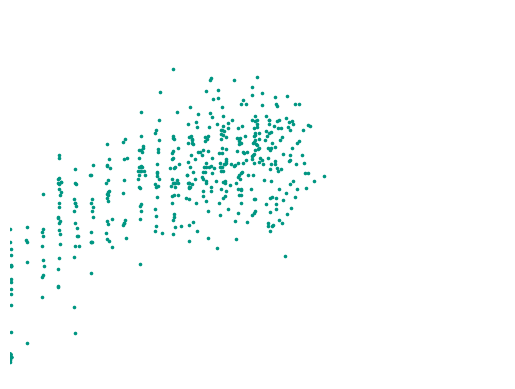

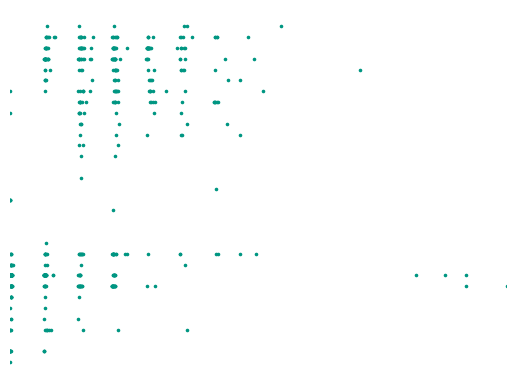

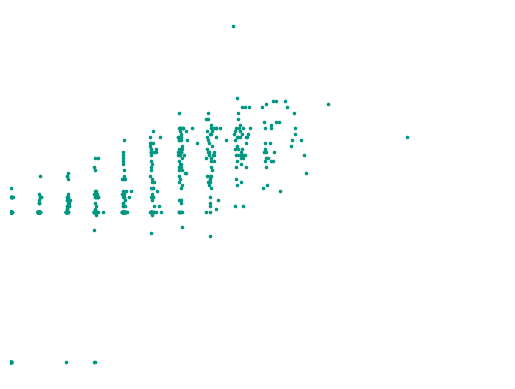

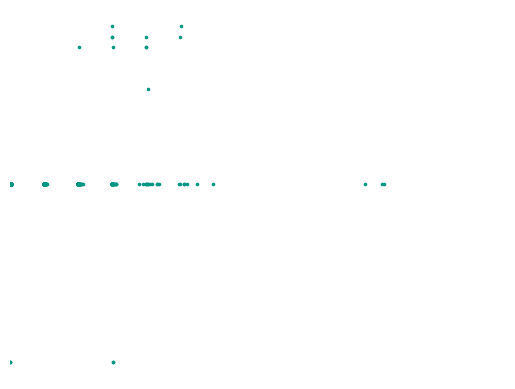

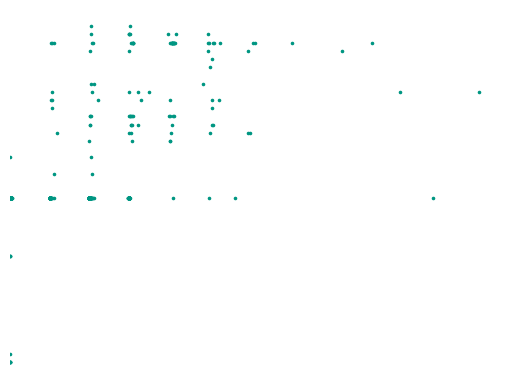

In [17]:
for ds in range(13):
    plt.figure()
    # plt.scatter(power_points_pt[ds].flatten(), acc_points_pt[ds].flatten(), color=FC.Green, s=2.5)
    plt.scatter(power_points_ft[ds].flatten(), acc_points_ft[ds].flatten(), color=FC.Green, s=2.5)
    # plt.title(f'{ds}')
    plt.xlim(lims[ds])

    plt.axis('off')
    plt.savefig(f"../figures/{ds}.pdf", format='pdf', bbox_inches='tight', transparent=True)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.spatial import ConvexHull
from scipy.special import comb
from scipy.interpolate import PchipInterpolator, interp1d, CubicSpline, BSpline

# 生成示例数据点（替换为你的实际数据）
points = torch.randn([100, 2]).numpy()

def compute_auxiliary_points(points):
    auxiliary_point_1 = points.min(axis=0) - 1e-4
    auxiliary_point_2 = points.max(axis=0) + 1e-4
    return auxiliary_point_1, auxiliary_point_2

def filter_pareto_front(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_points = hull_points[np.argsort(hull_points[:, 0])]
    pareto_front = [hull_points[0]]
    for point in hull_points[1:]:
        if point[1] > pareto_front[-1][1]:
            pareto_front.append(point)
    return np.array(pareto_front)

def bernstein_poly(i, n, t):
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bernstein_poly(i, n, t):
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bezier_curve(points, n_times=1000):
    n_points = len(points)
    x_points = np.array([p[0] for p in points])
    y_points = np.array([p[1] for p in points])
    
    t = np.linspace(0.0, 1.0, n_times)
    polynomial_array = np.array([bernstein_poly(i, n_points - 1, t) for i in range(0, n_points)])
    
    xvals = np.dot(x_points, polynomial_array)
    yvals = np.dot(y_points, polynomial_array)
    
    return xvals, yvals

def pchip_curve(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    pchip = PchipInterpolator(x, y)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = pchip(x_smooth)
    return x_smooth, y_smooth

def linear_curve(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    linear_interp = interp1d(x, y, kind='linear')
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = linear_interp(x_smooth)
    return x_smooth, y_smooth

def cubic_spline_curve(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    cubic_spline = CubicSpline(x, y)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = cubic_spline(x_smooth)
    return x_smooth, y_smooth

def b_spline_curve(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    k = 3  # Cubic B-spline
    t = np.linspace(x.min(), x.max(), len(x) - k + 1)
    t = np.concatenate(([x.min()] * k, t, [x.max()] * k))
    b_spline = BSpline(t, y, k)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = b_spline(x_smooth)
    return x_smooth, y_smooth

def polynomial_fit(points, degree=3, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    coefs = np.polyfit(x, y, degree)
    poly = np.poly1d(coefs)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = poly(x_smooth)
    return x_smooth, y_smooth

def exponential_fit(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    y = y[y > 0]
    x = x[:len(y)]
    coefs = np.polyfit(x, np.log(y), 1)
    exp_fit = lambda x: np.exp(coefs[1]) * np.exp(coefs[0] * x)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = exp_fit(x_smooth)
    return x_smooth, y_smooth

def power_fit(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    valid_indices = (x > 0) & (y > 0)
    x = x[valid_indices]
    y = y[valid_indices]
    coefs = np.polyfit(np.log(x), np.log(y), 1)
    power_fit = lambda x: np.exp(coefs[1]) * x ** coefs[0]
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = power_fit(x_smooth)
    return x_smooth, y_smooth

def logarithmic_fit(points, n_times=1000):
    x = points[:, 0]
    y = points[:, 1]
    valid_indices = x > 0
    x = x[valid_indices]
    y = y[valid_indices]
    coefs = np.polyfit(np.log(x), y, 1)
    log_fit = lambda x: coefs[1] + coefs[0] * np.log(x)
    x_smooth = np.linspace(x.min(), x.max(), n_times)
    y_smooth = log_fit(x_smooth)
    return x_smooth, y_smooth

def clean_data(data, lim):
    clean_data = []
    for i in range(data.shape[0]):
        if data[i,0] <= lim:
            clean_data.append(data[i])
    return np.array(clean_data)
    
def pareto_front(points, limx=None, method='bezier', title='default', delta=0, deltax=0):
    if limx:
        points = clean_data(points, limx[1])
    auxiliary_point_1, auxiliary_point_2 = compute_auxiliary_points(points)
    if limx:
        auxiliary_point_2[0] = limx[1]
    
    pareto = filter_pareto_front(points)
    pareto = np.vstack([pareto, auxiliary_point_2])
    
    if method == 'bezier':
        x_smooth, y_smooth = bezier_curve(pareto)
    elif method == 'pchip':
        x_smooth, y_smooth = pchip_curve(pareto)
    elif method == 'linear':
        x_smooth, y_smooth = linear_curve(pareto)
    elif method == 'cubic_spline':
        x_smooth, y_smooth = cubic_spline_curve(pareto)
    elif method == 'b_spline':
        x_smooth, y_smooth = b_spline_curve(pareto)
    elif method == 'polynomial':
        x_smooth, y_smooth = polynomial_fit(pareto)
    elif method == 'exponential':
        x_smooth, y_smooth = exponential_fit(pareto)
    elif method == 'power':
        x_smooth, y_smooth = power_fit(pareto)
    elif method == 'logarithmic':
        x_smooth, y_smooth = logarithmic_fit(pareto)
    else:
        raise ValueError("Invalid method. Use 'bezier', 'pchip', 'linear', 'cubic_spline', 'b_spline', 'polynomial', 'exponential', 'power', or 'logarithmic'.")

    y_smooth += delta
    x_smooth += deltax
    
    return x_smooth, y_smooth

In [19]:
methods = ['bezier']*13
methods[0] = 'linear'
methods[6] = 'cubic_spline'
methods[10] = 'pchip'

deltas = [0.] * 13
deltas[1] = 0.02
deltas[2] = 0.005
deltas[4] = 0.005
deltas[5] = 0.012
deltas[7] = 0.008

deltaxs = [0.] * 13
deltaxs[2] = -0.08
deltaxs[8] = -0.12

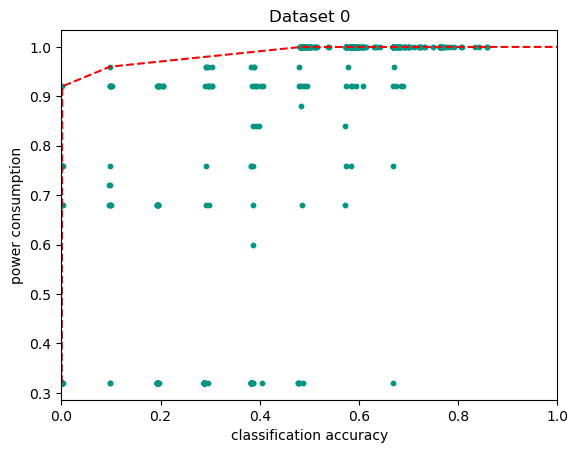

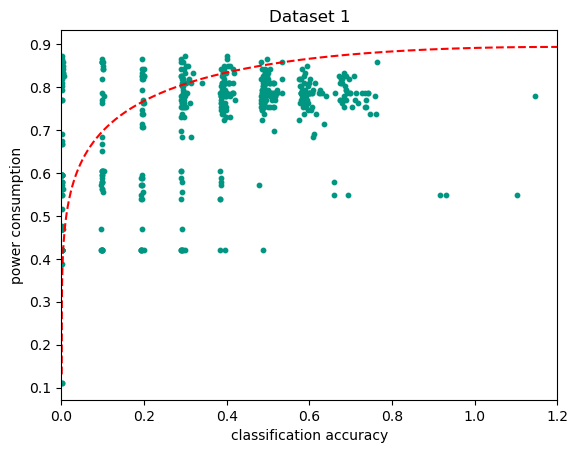

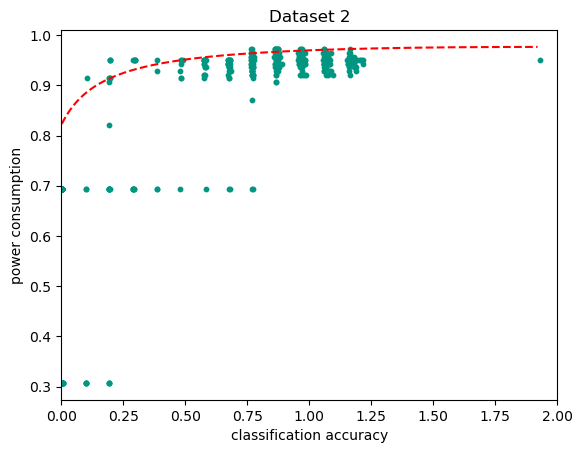

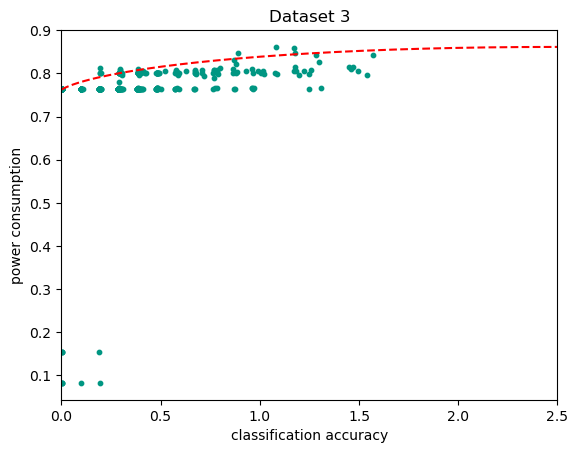

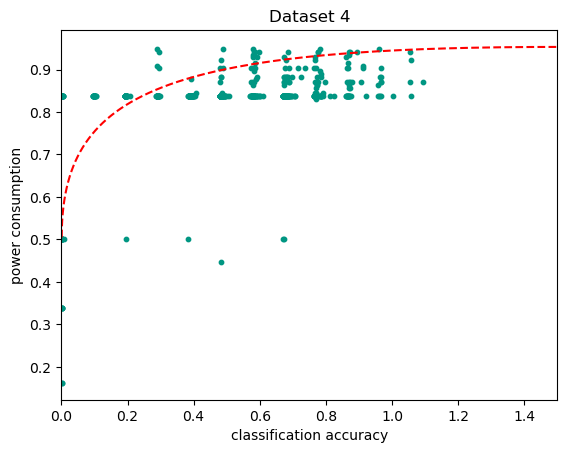

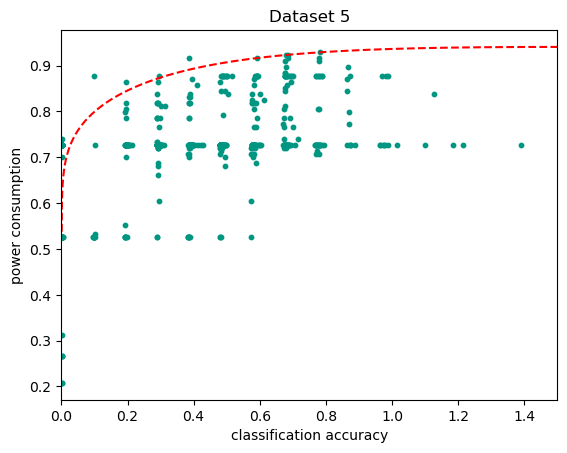

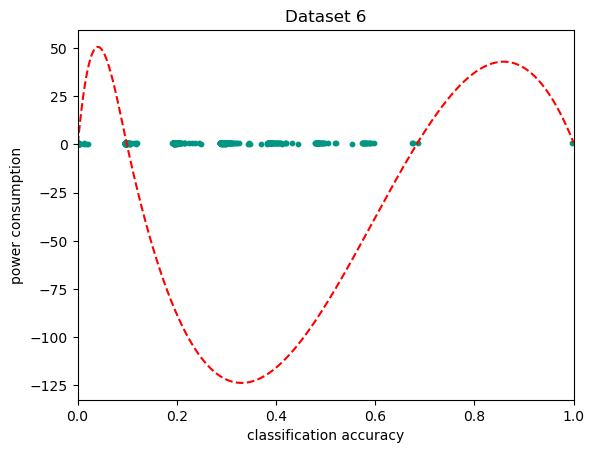

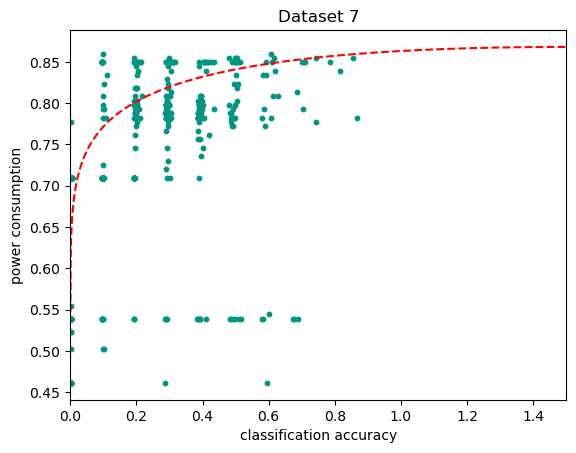

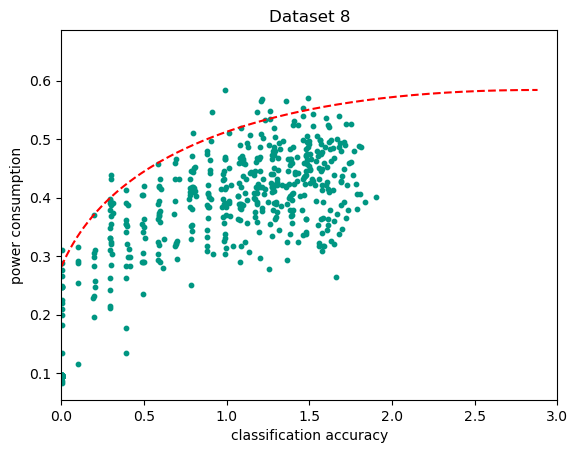

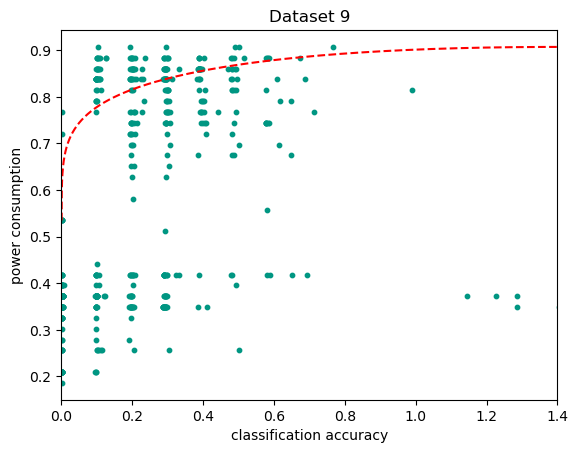

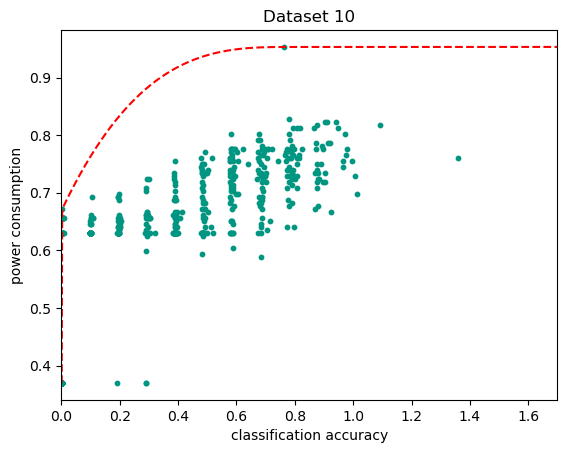

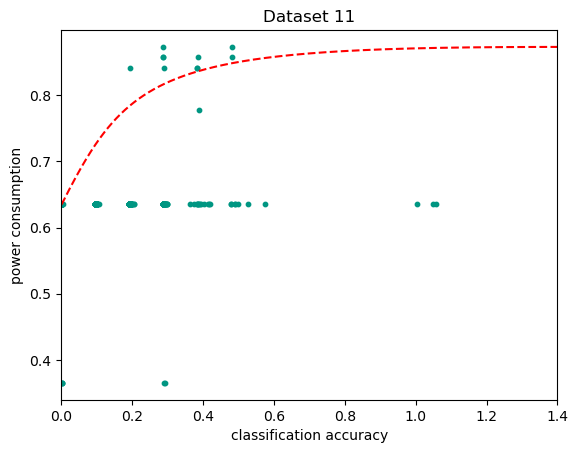

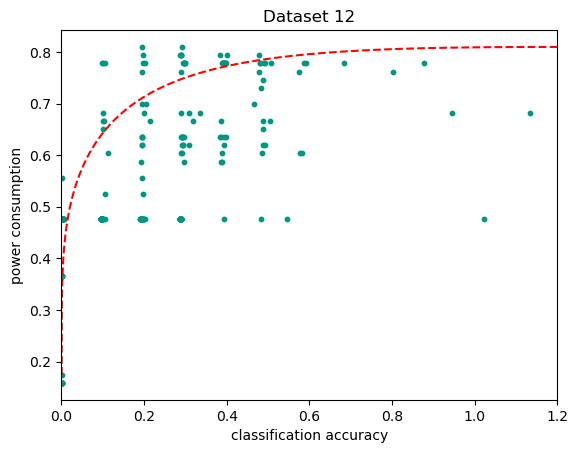

In [20]:
paretos_x = []
paretos_y = []

for ds in range(13):
    data = torch.stack([power_points_ft[ds].flatten(), acc_points_ft[ds].flatten()], dim=1).numpy()
    if ds == 0:
        x = data[:,0]
        y = data[:,1]
        invalid = (x<0.48) & (y>0.98)
        valid = ~invalid
        data = data[valid]
    if ds == 2:
        x = data[:,0]
        y = data[:,1]
        invalid = (x<0.7) & (y>0.95)
        valid = ~invalid
        data = data[valid]
    pareto_x, pareto_y = pareto_front(data, lims[ds], methods[ds], ds, delta=deltas[ds], deltax=deltaxs[ds])
    
    paretos_x.append(pareto_x)
    paretos_y.append(pareto_y)

    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], color=FC.Green, s=10)
    plt.plot(pareto_x, pareto_y, '--', color='r')
    plt.xlabel('classification accuracy')
    plt.ylabel('power consumption')
    plt.xlim(lims[ds])
    
    plt.title(f'Dataset {ds}')
    
    # plt.axis('off')
    # plt.savefig(f"../figures/{ds}.pdf", format='pdf', bbox_inches='tight', transparent=True)
    plt.show()

In [46]:
paretos_x = np.array(paretos_x)
paretos_y = np.array(paretos_y)
pareto = np.stack([paretos_x,paretos_y])
pareto = torch.tensor(pareto).permute(1,0,2)
torch.save(pareto, '../RESULT/pareto.curves')

In [42]:
pareto

array([[[ 0.06940299,  0.07033452,  0.07126605, ...,  0.99813694,
          0.99906847,  1.        ],
        [ 0.03532514,  0.03585668,  0.03639229, ...,  1.1950654 ,
          1.19753098,  1.20000005],
        [-0.08744977, -0.08742761, -0.08739973, ...,  1.9144054 ,
          1.91721285,  1.92      ],
        ...,
        [-0.03123941, -0.02950644, -0.02777347, ...,  1.6965341 ,
          1.69826708,  1.70000005],
        [-0.04143561, -0.03854984, -0.03567312, ...,  1.39626571,
          1.39813071,  1.39999998],
        [ 0.09368986,  0.09395047,  0.09422146, ...,  1.19512191,
          1.19755766,  1.20000005]],

       [[ 0.54870087,  0.54973557,  0.55077026, ...,  1.00315488,
          1.00315941,  1.00316393],
        [ 0.26749994,  0.26833955,  0.26918272, ...,  0.87554234,
          0.8755455 ,  0.87554695],
        [ 0.75678069,  0.75708306,  0.7573863 , ...,  0.97985631,
          0.97985753,  0.9798584 ],
        ...,
        [ 0.5834986 ,  0.58557368,  0.58764247, ...,  